# Implement Minimal Model Example
Test if model in README.md actually works

In [110]:
import xso
import numpy as np

@xso.component
class Variable:
    var = xso.variable(dims=[(), 'var'], description='basic state variable')
    
@xso.component
class LinearGrowth:
    var_ext = xso.variable(foreign=True, dims=[(), 'var'], flux='growth', description='external state variable')
    rate = xso.parameter(description='linear growth rate')
    @xso.flux(dims=[(), 'var'])
    def growth(self, var_ext, rate):
        return var_ext * rate + self.m.log(1)
    
model = xso.create({'Var':Variable,'Growth':LinearGrowth})

input_ds = xso.setup(solver='stepwise',
                     model=model,
                     time=np.arange(1,10),
                     input_vars={
                         'Var':{'var_label':'X', 'var_init':1},
                         'Growth':{'var_ext':'X', 'rate':1.},
                     })

with model:
    output_ds = input_ds.xsimlab.run()
    
print(output_ds)

input_ds = xso.setup(solver='solve_ivp',
                     model=model,
                     time=np.arange(1,10),
                     input_vars={
                         'Var':{'var_label':'X', 'var_init':[1, 0.1]},
                         'Growth':{'var_ext':'X', 'rate':1.},
                     })

with model:
    output_ds = input_ds.xsimlab.run()
    

print(output_ds)

<xarray.Dataset>
Dimensions:               (time: 9, time_input: 9)
Coordinates:
  * time                  (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * time_input            (time_input) int64 1 2 3 4 5 6 7 8 9
Data variables:
    Core__solver_type     <U8 'stepwise'
    Growth__growth_value  (time) float64 1.0 1.0 2.0 4.0 ... 32.0 64.0 128.0
    Growth__rate          float64 1.0
    Growth__var_ext       <U1 'X'
    Time__time_input      (time) int64 1 2 3 4 5 6 7 8 9
    Var__var              (time) float64 1.0 2.0 4.0 8.0 ... 64.0 128.0 256.0
    Var__var_init         int64 1
    Var__var_label        <U1 'X'
<xarray.Dataset>
Dimensions:               (var: 2, time: 9, clock: 2)
Coordinates:
  * clock                 (clock) int64 1 2
  * time                  (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
Dimensions without coordinates: var
Data variables:
    Core__solver_type     <U9 'solve_ivp'
    Growth__growth_value  (var, time) float64 1.718 1.718 4.668 ... 69.

# DETAILED STEPS

In [1]:
import xso
import xsimlab as xs

import numpy as np

In [2]:
@xso.component
class Variable:
    value = xso.variable(description='basic state variable', attrs={'units':'µM'})

In [3]:
@xso.component
class LinearGrowth:
    var_ext = xso.variable(foreign=True, flux='growth', description='external state variable')
    rate = xso.parameter(description='linear growth rate', attrs={'units':'$d^{-1}$'})

    @xso.flux
    def growth(self, var_ext, rate):
        return var_ext * rate

In [4]:
model = xso.create({'Var':Variable,'Growth':LinearGrowth}, time_unit='d')

In [5]:
print(model)

<xsimlab.Model (5 processes, 6 inputs)>
Core
    solver_type     [in] solver type to use for model
Time
    time_input      [in] ('time',) sequence of time for which to so...
Var
    value_label     [in] label / basic state variable
    value_init      [in] initial value / basic state variable
Growth
    var_ext         [in] label reference / external state variable
    rate            [in] parameter / linear growth rate
Solver



In [6]:
input_ds = xso.setup(solver='solve_ivp',
                     model=model,
                     time=np.arange(1,10,.1),
                     input_vars={
                         'Var':{'value_label':'X', 'value_init':1},
                         'Growth':{'var_ext':'X', 'rate':1.},
                     })

In [10]:
print(input_ds)

<xarray.Dataset>
Dimensions:            (clock: 2, time: 90)
Coordinates:
  * clock              (clock) float64 1.0 1.1
Dimensions without coordinates: time
Data variables:
    Var__value_label   <U1 'X'
    Var__value_init    int64 1
    Growth__var_ext    <U1 'X'
    Growth__rate       float64 1.0
    Core__solver_type  <U9 'solve_ivp'
    Time__time_input   (time) float64 1.0 1.1 1.2 1.3 1.4 ... 9.6 9.7 9.8 9.9
Attributes:
    __xsimlab_output_vars__:  Var__value,Growth__growth_value


In [7]:
with model:
    output_ds = input_ds.xsimlab.run()

In [11]:
print(output_ds)

<xarray.Dataset>
Dimensions:               (time: 90, clock: 2)
Coordinates:
  * clock                 (clock) float64 1.0 1.1
  * time                  (time) float64 0.0 0.1 0.2 0.3 0.4 ... 8.6 8.7 8.8 8.9
Data variables:
    Core__solver_type     <U9 'solve_ivp'
    Growth__growth_value  (time) float64 1.052 1.052 ... 6.313e+03 6.969e+03
    Growth__rate          float64 1.0
    Growth__var_ext       <U1 'X'
    Time__time_input      (time) float64 1.0 1.1 1.2 1.3 1.4 ... 9.6 9.7 9.8 9.9
    Var__value            (time) float64 1.0 1.105 1.221 ... 6.626e+03 7.323e+03
    Var__value_init       int64 1
    Var__value_label      <U1 'X'


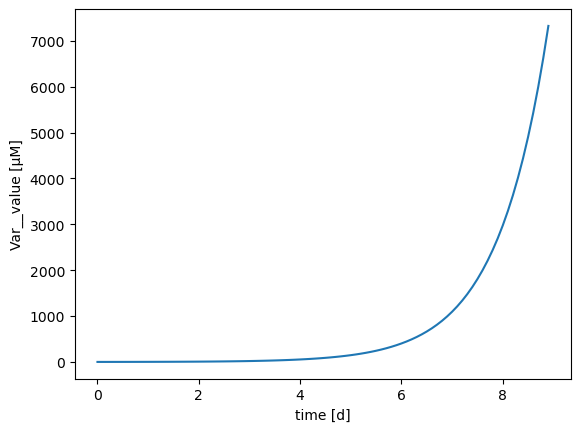

In [12]:
output_ds.Var__value.plot()

In [13]:
output_ds.xsimlab.plot.line(x='time', hue='clock')

AttributeError: 'SimlabAccessor' object has no attribute 'plot'

# Now let's try out the fancy stuff and put that into the readme

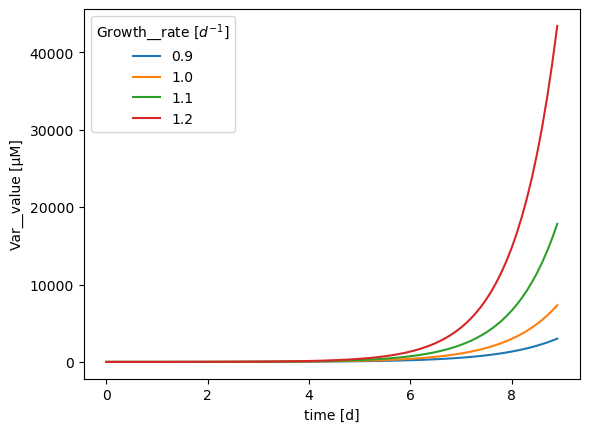

In [121]:
with model:
    batchout_ds = (input_ds
     .xsimlab.update_vars(
         input_vars={'Growth': {'rate': ('batch', [0.9, 1.0, 1.1, 1.2])}}
     )
     .xsimlab.run(parallel=True, batch_dim='batch')
     .swap_dims({'batch':'Growth__rate'})
     .Var__value.plot.line(x='time')
     )

import matplotlib.pyplot as plt
plt.savefig("GrowthRate_BatchOut.png")

In [14]:
batchout_ds=batchout_ds.swap_dims({'batch':'Growth__rate'})

AttributeError: 'list' object has no attribute 'swap_dims'

In [86]:
batchout_ds.Growth__rate

<xarray.DataArray 'Growth__rate' (Growth__rate: 4)>
array([0.9, 1. , 1.1, 1.2])
Coordinates:
  * Growth__rate  (Growth__rate) float64 0.9 1.0 1.1 1.2
Attributes:
    description:  linear growth rate

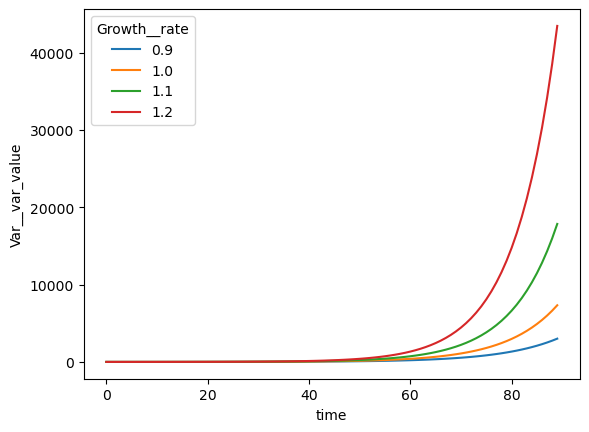

In [87]:
batchout_ds.Var__var_value.plot.line(x='time')


In [41]:
output.Growth__rate

<xarray.DataArray 'Growth__rate' (batch: 4)>
array([0.9, 1. , 1.1, 1.2])
Dimensions without coordinates: batch
Attributes:
    description:  linear growth rate

In [15]:
with model:
    input_ds.xsimlab.update_vars()